In [21]:
import os
import glob
import rasterio
import numpy as np
import pandas as pd
from rasterio.enums import Resampling
from rasterio.warp import reproject
import re

import text


###############################################################################
# 1. Use the revised detect_dataset_type and extract_year
###############################################################################

def detect_dataset_type(file_path):
    name = os.path.basename(file_path)
    name_lower = name.lower()

    if "population_" in name_lower:
        return "pop"
    elif "ndvi_" in name_lower:
        return "ndvi"
    elif "lst_" in name_lower:
        return "lst"
    elif "_gp" in name_lower:
        return "gpp"
    elif "lct" in name_lower:
        return "landcover"
    elif re.search(r'(20\d{2})r\.tif$', name_lower):
        return "precip"
    else:
        return None

def extract_year(file_path):
    import re
    name = os.path.basename(file_path)
    match = re.search(r'(20\d{2})', name)
    if match:
        return int(match.group(1))
    return None

###############################################################################
# 2. Search folders for TIFs
###############################################################################
base_folder = "Datasets_Hackathon 1/Datasets_Hackathon"  # Adjust if needed
all_tifs = glob.glob(os.path.join(base_folder, "**/*.tif"), recursive=True)

files_dict = {
    "landcover": {},
    "ndvi": {},
    "lst": {},
    "pop": {},
    "gpp": {},
    "precip": {}
}

for fp in all_tifs:
    dset_type = detect_dataset_type(fp)
    if not dset_type:
        continue
    year = extract_year(fp)
    if not year:
        continue
    files_dict[dset_type][year] = fp

# For years 2021-2023, copy population from 2020 if missing
for y in [2021, 2022, 2023]:
    if y not in files_dict["pop"] and 2020 in files_dict["pop"]:
        files_dict["pop"][y] = files_dict["pop"][2020]

###############################################################################
# 3. Pick a Land Cover raster to define resolution/extent
###############################################################################
# We'll try 2010, or any other year available.
if 2010 in files_dict["landcover"]:
    ref_path = files_dict["landcover"][2010]
else:
    lc_years = sorted(files_dict["landcover"].keys())
    if lc_years:
        ref_path = files_dict["landcover"][lc_years[0]]
    else:
        raise RuntimeError("No land cover files found!")

with rasterio.open(ref_path) as src_ref:
    ref_data = src_ref.read(1)
    ref_profile = src_ref.profile
    ref_transform = src_ref.transform
    ref_crs = src_ref.crs
    ref_height, ref_width = ref_data.shape

###############################################################################
# 4. Helper to resample
###############################################################################
def resample_to_reference(source_path, cap_gpp=False):
    with rasterio.open(source_path) as src:
        arr_src = src.read(1)
        transform_src = src.transform
        crs_src = src.crs
        
        dest_data = np.zeros((ref_height, ref_width), dtype=np.float32)

        reproject(
            arr_src,
            dest_data,
            src_transform=transform_src,
            src_crs=crs_src,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.bilinear
        )

        # Cap GPP if needed
        if cap_gpp:
            dest_data[dest_data > 4000] = 0
        
        return dest_data

###############################################################################
# 5. Load and resample all data for 2010-2023
###############################################################################
import scipy.ndimage
years = range(2010, 2024)
data_by_type = {k: {} for k in files_dict.keys()}

for y in years:
    # landcover
    if y in files_dict["landcover"]:
        data_by_type["landcover"][y] = resample_to_reference(files_dict["landcover"][y])
    else:
        data_by_type["landcover"][y] = None
    
    # ndvi
    if y in files_dict["ndvi"]:
        data_by_type["ndvi"][y] = resample_to_reference(files_dict["ndvi"][y])
    else:
        data_by_type["ndvi"][y] = None

    # lst
    if y in files_dict["lst"]:
        data_by_type["lst"][y] = resample_to_reference(files_dict["lst"][y])
    else:
        data_by_type["lst"][y] = None

    # pop
    if y in files_dict["pop"]:
        data_by_type["pop"][y] = resample_to_reference(files_dict["pop"][y])
    else:
        data_by_type["pop"][y] = None

    # gpp
    if y in files_dict["gpp"]:
        data_by_type["gpp"][y] = resample_to_reference(files_dict["gpp"][y], cap_gpp=True)
    else:
        data_by_type["gpp"][y] = None

    # precip
    if y in files_dict["precip"]:
        with rasterio.open(files_dict["precip"][y]) as src:
            precip_arr = src.read(1)  # Read precipitation raster
            
            # Handle missing values (replace 65533 with NaN)
            precip_arr = precip_arr.astype(np.float32)  # Ensure float type for NaN handling
            precip_arr[precip_arr == 65533] = np.nan

            # Ensure it matches the reference resolution
            dest_data = np.zeros((ref_height, ref_width), dtype=np.float32)

            reproject(
                source=precip_arr,
                destination=dest_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.nearest  # Assign nearest precipitation values to pixels
            )

            # Fill NaN values with nearest non-NaN neighbor
            nan_mask = np.isnan(dest_data) | (dest_data == -3.402823e+38)
            if np.any(nan_mask):  # Only run if there are NaNs
                filled_data = dest_data.copy()
                filled_data[nan_mask] = scipy.ndimage.distance_transform_edt(nan_mask) * 0
                filled_data = scipy.ndimage.distance_transform_edt(nan_mask, return_distances=False, return_indices=True)
                filled_data = dest_data[tuple(filled_data)]
                dest_data = filled_data  # Replace NaN-filled data

            data_by_type["precip"][y] = dest_data
    else:
        data_by_type["precip"][y] = None

###############################################################################
# 6. Assemble into a DataFrame
###############################################################################
rows = []
for y in years:
    lc_arr   = data_by_type["landcover"][y]
    if lc_arr is None:
        # skip if no landcover for this year
        continue
    
    # flatten landcover
    lc_flat = lc_arr.flatten()
    
    # flatten other variables or fill with NaN
    ndvi_arr = data_by_type["ndvi"][y]
    ndvi_flat = ndvi_arr.flatten() if ndvi_arr is not None else np.full(lc_flat.shape, np.nan)
    
    lst_arr = data_by_type["lst"][y]
    lst_flat = lst_arr.flatten() if lst_arr is not None else np.full(lc_flat.shape, np.nan)

    pop_arr = data_by_type["pop"][y]
    pop_flat = pop_arr.flatten() if pop_arr is not None else np.full(lc_flat.shape, np.nan)

    gpp_arr = data_by_type["gpp"][y]
    gpp_flat = gpp_arr.flatten() if gpp_arr is not None else np.full(lc_flat.shape, np.nan)

    prc_arr = data_by_type["precip"][y]
    prc_flat = prc_arr.flatten() if prc_arr is not None else np.full(lc_flat.shape, np.nan)

    # Make a DataFrame for this year
    temp_df = pd.DataFrame({
        f"LC_{y}": lc_flat,
        f"NDVI_{y}": ndvi_flat,
        f"LST_{y}": lst_flat,
        f"POP_{y}": pop_flat,
        f"GPP_{y}": gpp_flat,
        f"PRECIP_{y}": prc_flat,
        "pixel_id": np.arange(len(lc_flat))
    })
    rows.append(temp_df)

# Merge across all years on pixel_id => wide table
df_full = None
for year_df in rows:
    if df_full is None:
        df_full = year_df
    else:
        df_full = df_full.merge(year_df, on="pixel_id", how="outer")

###############################################################################
# 7. Exclude invalid land cover classes -128 and 255
###############################################################################
lc_cols = [c for c in df_full.columns if c.startswith("LC_")]
mask_invalid = np.zeros(len(df_full), dtype=bool)
for c in lc_cols:
    mask_invalid |= (df_full[c] == -128) | (df_full[c] == 255)

df_filtered = df_full[~mask_invalid].copy()

for y in years:
    df_filtered[f"NDVI_{y}"]= 0.0001 *  df_filtered[f"NDVI_{y}"]

print("Final DataFrame shape:", df_filtered.shape)
print(df_filtered.head())

# Save to CSV if desired
df_filtered.head().to_csv("final_pixel_dataframe.csv", index=False)
print("DataFrame saved to final_pixel_dataframe.csv")


Final DataFrame shape: (168212, 85)
      LC_2010  NDVI_2010   LST_2010  POP_2010  GPP_2010   PRECIP_2010  \
475      16.0   0.100435  40.922581  0.006259       0.0 -3.402823e+38   
1039     16.0   0.108242  41.056068  0.005568       0.0 -3.402823e+38   
1040     16.0   0.100624  40.807373  0.005553       0.0 -3.402823e+38   
1603     16.0   0.109151  40.763355  0.005525       0.0 -3.402823e+38   
1604     16.0   0.101587  40.485077  0.005415       0.0 -3.402823e+38   

      pixel_id  LC_2011  NDVI_2011   LST_2011  ...   LST_2022  POP_2022  \
475        475     16.0   0.103633  41.960651  ...  39.550652  0.007126   
1039      1039     16.0   0.107574  42.358791  ...  39.756775  0.005950   
1040      1040     16.0   0.100824  41.900337  ...  39.534119  0.005174   
1603      1603     16.0   0.106553  42.219372  ...  39.943565  0.005401   
1604      1604     16.0   0.099491  41.864021  ...  39.667461  0.004754   

      GPP_2022   PRECIP_2022  LC_2023  NDVI_2023   LST_2023  POP_2023  \
4

In [22]:
reference_tif = "Datasets_Hackathon 1/Datasets_Hackathon/Modis_Land_Cover_Data/2010LCT.tif"

with rasterio.open(reference_tif) as src:
    transform = src.transform  # affine transform (maps col/row to x/y)
    width = src.width          # number of columns
    height = src.height        # number of rows
    crs = src.crs              # coordinate reference system (just for your info)

print("Raster width:", width, "height:", height)
print("Transform:", transform)
print("CRS:", crs)

import numpy as np

df_filtered["row"] = df_filtered["pixel_id"] // width
df_filtered["col"] = df_filtered["pixel_id"] % width

print(df_filtered[["pixel_id", "row", "col"]].head())

xcoords = []
ycoords = []

for i, row_data in df_filtered.iterrows():
    r = row_data["row"]
    c = row_data["col"]
    # Transform to x,y
    x, y = transform * (c, r)  # note the order: (col, row)
    xcoords.append(x)
    ycoords.append(y)

df_filtered["xcoord"] = xcoords
df_filtered["ycoord"] = ycoords

print(df_filtered[["pixel_id", "row", "col", "xcoord", "ycoord"]].head())

df = df_filtered


Raster width: 565 height: 769
Transform: | 463.31, 0.00,-1378818.64|
| 0.00,-463.31, 2036259.39|
| 0.00, 0.00, 1.00|
CRS: PROJCS["Unknown_datum_based_upon_the_custom_spheroid_Sinusoidal",GEOGCS["GCS_Unknown_datum_based_upon_the_custom_spheroid",DATUM["D_Not_specified_based_on_custom_spheroid",SPHEROID["Custom_spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
      pixel_id  row  col
475        475    0  475
1039      1039    1  474
1040      1040    1  475
1603      1603    2  473
1604      1604    2  474
      pixel_id  row  col        xcoord        ycoord
475        475    0  475 -1.158745e+06  2.036259e+06
1039      1039    1  474 -1.159208e+06  2.035796e+06
1040      1040    1  475 -1.158745e+06  2.035796e+06
1603      1603

In [23]:
years = range(2010, 2024)  # stops at 2022, so we can compare to y+1 up to 2023

rows = []
# Loop through each year to create feature-target pairs
for y in years:
    next_year = y + 1  # Predict desertification in next year
        
    
    temp_df = df[[
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}",  f"GPP_{y}", "xcoord", "ycoord",  f"LC_{y}"
    ]].copy()
    
     # Rename columns to be consistent across years
    temp_df.columns = ["NDVI", "LST", "POP", "GPP", "xcoord", "ycoord", "LC"]
    if y < 2023:
        temp_df["becomes_desert"] = (df[f"LC_{next_year}"] == 16).astype(int)
        temp_df["becomes_vegetation"]  = ((df[f"LC_{next_year}"] == 7) | (df[f"LC_{next_year}"] == 10)).astype(int) 

    temp_df["year"] = y

    rows.append(temp_df)

# Convert to DataFrame
df_transformed = pd.concat(rows, ignore_index=True)
print(df_transformed.head())

       NDVI        LST       POP  GPP        xcoord        ycoord    LC  \
0  0.100435  40.922581  0.006259  0.0 -1.158745e+06  2.036259e+06  16.0   
1  0.108242  41.056068  0.005568  0.0 -1.159208e+06  2.035796e+06  16.0   
2  0.100624  40.807373  0.005553  0.0 -1.158745e+06  2.035796e+06  16.0   
3  0.109151  40.763355  0.005525  0.0 -1.159672e+06  2.035333e+06  16.0   
4  0.101587  40.485077  0.005415  0.0 -1.159208e+06  2.035333e+06  16.0   

   becomes_desert  becomes_vegetation  year  
0             1.0                 0.0  2010  
1             1.0                 0.0  2010  
2             1.0                 0.0  2010  
3             1.0                 0.0  2010  
4             1.0                 0.0  2010  


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["becomes_desert"])

X = df_clean[feature_cols].values  # Features
y = df_clean["becomes_desert"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9829
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    321878
         1.0       0.96      0.97      0.97    115474

    accuracy                           0.98    437352
   macro avg       0.98      0.98      0.98    437352
weighted avg       0.98      0.98      0.98    437352



In [25]:
X_2024 = df_transformed.loc[df_transformed["year"] == 2023, feature_cols].values
Y_dessert_2024 = clf.predict_proba(X_2024)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["becomes_vegetation"])

X = df_clean[feature_cols].values  # Features
y = df_clean["becomes_vegetation"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9829
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    115497
         1.0       0.99      0.99      0.99    321855

    accuracy                           0.98    437352
   macro avg       0.98      0.98      0.98    437352
weighted avg       0.98      0.98      0.98    437352



In [27]:
X_2024 = df_transformed.loc[df_transformed["year"] == 2023, feature_cols].values
Y_vega_2024 = clf.predict_proba(X_2024)

In [28]:
years = range(2010, 2024)  # stops at 2022, so we can compare to y+1 up to 2023

rows = []
# Loop through each year to create feature-target pairs
for y in years:
    next_year = y + 2  # Predict desertification in next year
        
    
    temp_df = df[[
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}",  f"GPP_{y}", "xcoord", "ycoord",  f"LC_{y}"
    ]].copy()
    
     # Rename columns to be consistent across years
    temp_df.columns = ["NDVI", "LST", "POP", "GPP", "xcoord", "ycoord", "LC"]
    if y < 2022:
        temp_df["becomes_desert"] = (df[f"LC_{next_year}"] == 16).astype(int)
        temp_df["becomes_vegetation"]  = ((df[f"LC_{next_year}"] == 7) | (df[f"LC_{next_year}"] == 10)).astype(int) 

    temp_df["year"] = y

    rows.append(temp_df)

# Convert to DataFrame
df_transformed = pd.concat(rows, ignore_index=True)
print(df_transformed.head())

       NDVI        LST       POP  GPP        xcoord        ycoord    LC  \
0  0.100435  40.922581  0.006259  0.0 -1.158745e+06  2.036259e+06  16.0   
1  0.108242  41.056068  0.005568  0.0 -1.159208e+06  2.035796e+06  16.0   
2  0.100624  40.807373  0.005553  0.0 -1.158745e+06  2.035796e+06  16.0   
3  0.109151  40.763355  0.005525  0.0 -1.159672e+06  2.035333e+06  16.0   
4  0.101587  40.485077  0.005415  0.0 -1.159208e+06  2.035333e+06  16.0   

   becomes_desert  becomes_vegetation  year  
0             1.0                 0.0  2010  
1             1.0                 0.0  2010  
2             1.0                 0.0  2010  
3             1.0                 0.0  2010  
4             1.0                 0.0  2010  


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["becomes_desert"])

X = df_clean[feature_cols].values  # Features
y = df_clean["becomes_desert"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9829
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    321878
         1.0       0.96      0.97      0.97    115474

    accuracy                           0.98    437352
   macro avg       0.98      0.98      0.98    437352
weighted avg       0.98      0.98      0.98    437352



In [31]:
X_2025 = df_transformed.loc[df_transformed["year"] == 2023, feature_cols].values
Y_dessert_2025 = clf.predict_proba(X_2025)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["becomes_vegetation"])

X = df_clean[feature_cols].values  # Features
y = df_clean["becomes_vegetation"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9829
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    115497
         1.0       0.99      0.99      0.99    321855

    accuracy                           0.98    437352
   macro avg       0.98      0.98      0.98    437352
weighted avg       0.98      0.98      0.98    437352



In [34]:
Y_vega_2025 = clf.predict_proba(X_2025)

In [35]:
years = range(2010, 2024)  # stops at 2022, so we can compare to y+1 up to 2023

rows = []
# Loop through each year to create feature-target pairs
for y in years:
    next_year = y + 3  # Predict desertification in next year
        
    
    temp_df = df[[
        f"NDVI_{y}", f"LST_{y}", f"POP_{y}",  f"GPP_{y}", "xcoord", "ycoord",  f"LC_{y}"
    ]].copy()
    
     # Rename columns to be consistent across years
    temp_df.columns = ["NDVI", "LST", "POP", "GPP", "xcoord", "ycoord", "LC"]
    if y < 2021:
        temp_df["becomes_desert"] = (df[f"LC_{next_year}"] == 16).astype(int)
        temp_df["becomes_vegetation"]  = ((df[f"LC_{next_year}"] == 7) | (df[f"LC_{next_year}"] == 10)).astype(int) 

    temp_df["year"] = y

    rows.append(temp_df)

# Convert to DataFrame
df_transformed = pd.concat(rows, ignore_index=True)
print(df_transformed.head())

       NDVI        LST       POP  GPP        xcoord        ycoord    LC  \
0  0.100435  40.922581  0.006259  0.0 -1.158745e+06  2.036259e+06  16.0   
1  0.108242  41.056068  0.005568  0.0 -1.159208e+06  2.035796e+06  16.0   
2  0.100624  40.807373  0.005553  0.0 -1.158745e+06  2.035796e+06  16.0   
3  0.109151  40.763355  0.005525  0.0 -1.159672e+06  2.035333e+06  16.0   
4  0.101587  40.485077  0.005415  0.0 -1.159208e+06  2.035333e+06  16.0   

   becomes_desert  becomes_vegetation  year  
0             1.0                 0.0  2010  
1             1.0                 0.0  2010  
2             1.0                 0.0  2010  
3             1.0                 0.0  2010  
4             1.0                 0.0  2010  


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["becomes_desert"])

X = df_clean[feature_cols].values  # Features
y = df_clean["becomes_desert"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9640
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    272840
         1.0       0.91      0.96      0.93     97227

    accuracy                           0.96    370067
   macro avg       0.95      0.96      0.95    370067
weighted avg       0.97      0.96      0.96    370067



In [37]:
X_2026 = df_transformed.loc[df_transformed["year"] == 2023, feature_cols].values
Y_dessert_2026 = clf.predict_proba(X_2026)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features
feature_cols = ["NDVI", "LST", "POP", "GPP", "LC"]

# Drop missing values
df_clean = df_transformed.dropna(subset=feature_cols + ["becomes_vegetation"])

X = df_clean[feature_cols].values  # Features
y = df_clean["becomes_vegetation"].values   # Target

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 0.9640
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93     97249
         1.0       0.99      0.97      0.98    272818

    accuracy                           0.96    370067
   macro avg       0.95      0.96      0.95    370067
weighted avg       0.97      0.96      0.96    370067



In [39]:
Y_vega_2026 = clf.predict_proba(X_2026)

In [53]:
df_inputs = df_transformed[df_transformed["year"] == 2023].copy()

In [56]:
len(Y_vega_2026)

168212

In [62]:
Y_vega_2026

array([[0.99783898, 0.00216102],
       [0.99794251, 0.00205749],
       [0.99837459, 0.00162541],
       ...,
       [0.00344923, 0.99655077],
       [0.00344923, 0.99655077],
       [0.01082384, 0.98917616]], shape=(168212, 2))

In [65]:
import pandas as pd

# Create DataFrame from predictions
df_preds_2026_vega = pd.DataFrame({
    "year": 2026,
    "xcoord": df_inputs["xcoord"].values,
    "ycoord": df_inputs["ycoord"].values,
    "predicted_risk": Y_vega_2026[:,1]
})

print(df_preds_2026_vega.head())


   year        xcoord        ycoord  predicted_risk
0  2026 -1.158745e+06  2.036259e+06        0.002161
1  2026 -1.159208e+06  2.035796e+06        0.002057
2  2026 -1.158745e+06  2.035796e+06        0.001625
3  2026 -1.159672e+06  2.035333e+06        0.001896
4  2026 -1.159208e+06  2.035333e+06        0.001399


In [66]:
import pandas as pd

# Create DataFrame from predictions
df_preds_2026_des = pd.DataFrame({
    "year": 2026,
    "xcoord": df_inputs["xcoord"].values,
    "ycoord": df_inputs["ycoord"].values,
    "predicted_risk": Y_dessert_2026[:,1]
})

print(df_preds_2026_des.head())

   year        xcoord        ycoord  predicted_risk
0  2026 -1.158745e+06  2.036259e+06        0.997639
1  2026 -1.159208e+06  2.035796e+06        0.997468
2  2026 -1.158745e+06  2.035796e+06        0.998122
3  2026 -1.159672e+06  2.035333e+06        0.997813
4  2026 -1.159208e+06  2.035333e+06        0.998250


In [67]:
import pandas as pd

# Create DataFrame from predictions
df_preds_2025_des = pd.DataFrame({
    "year": 2025,
    "xcoord": df_inputs["xcoord"].values,
    "ycoord": df_inputs["ycoord"].values,
    "predicted_risk": Y_dessert_2025[:,1]
})

print(df_preds_2025_des.head())

   year        xcoord        ycoord  predicted_risk
0  2025 -1.158745e+06  2.036259e+06        0.998898
1  2025 -1.159208e+06  2.035796e+06        0.998953
2  2025 -1.158745e+06  2.035796e+06        0.999002
3  2025 -1.159672e+06  2.035333e+06        0.998935
4  2025 -1.159208e+06  2.035333e+06        0.998990


In [68]:
import pandas as pd

# Create DataFrame from predictions
df_preds_2025_vega = pd.DataFrame({
    "year": 2025,
    "xcoord": df_inputs["xcoord"].values,
    "ycoord": df_inputs["ycoord"].values,
    "predicted_risk": Y_vega_2025[:,1]
})

print(df_preds_2025_vega.head())

   year        xcoord        ycoord  predicted_risk
0  2025 -1.158745e+06  2.036259e+06        0.000923
1  2025 -1.159208e+06  2.035796e+06        0.000882
2  2025 -1.158745e+06  2.035796e+06        0.000794
3  2025 -1.159672e+06  2.035333e+06        0.000877
4  2025 -1.159208e+06  2.035333e+06        0.000807


In [69]:
import pandas as pd

# Create DataFrame from predictions
df_preds_2024_vega = pd.DataFrame({
    "year": 2024,
    "xcoord": df_inputs["xcoord"].values,
    "ycoord": df_inputs["ycoord"].values,
    "predicted_risk": Y_vega_2024[:,1]
})

print(df_preds_2024_vega.head())

   year        xcoord        ycoord  predicted_risk
0  2024 -1.158745e+06  2.036259e+06        0.000923
1  2024 -1.159208e+06  2.035796e+06        0.000882
2  2024 -1.158745e+06  2.035796e+06        0.000794
3  2024 -1.159672e+06  2.035333e+06        0.000877
4  2024 -1.159208e+06  2.035333e+06        0.000807


In [70]:
import pandas as pd

# Create DataFrame from predictions
df_preds_2024_des = pd.DataFrame({
    "year": 2024,
    "xcoord": df_inputs["xcoord"].values,
    "ycoord": df_inputs["ycoord"].values,
    "predicted_risk": Y_dessert_2024[:,1]
})

print(df_preds_2024_des.head())

   year        xcoord        ycoord  predicted_risk
0  2024 -1.158745e+06  2.036259e+06        0.998898
1  2024 -1.159208e+06  2.035796e+06        0.998953
2  2024 -1.158745e+06  2.035796e+06        0.999002
3  2024 -1.159672e+06  2.035333e+06        0.998935
4  2024 -1.159208e+06  2.035333e+06        0.998990


In [71]:
df_all_preds_des = pd.concat([df_preds_2024_des, df_preds_2025_des, df_preds_2026_des], ignore_index=True)


In [72]:
df_all_preds_vega = pd.concat([df_preds_2024_vega, df_preds_2025_vega, df_preds_2026_vega], ignore_index=True)

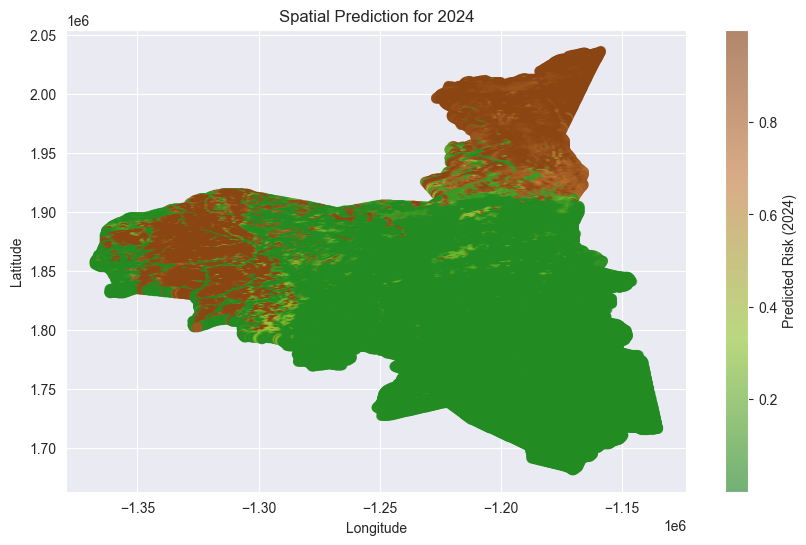

In [86]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap([ "forestgreen", "saddlebrown"])
brown_to_green = LinearSegmentedColormap.from_list(
    "BrownGreen", ["forestgreen", "yellowgreen", "peru","saddlebrown"]
)

def plot_predictions(df, year, column="predicted_risk"):
    df_year = df[df["year"] == year]
    plt.figure(figsize=(10, 6))
    plt.scatter(df_year["xcoord"], df_year["ycoord"], c=df_year[column], cmap=brown_to_green, alpha=0.6)
    plt.colorbar(label=f"Predicted Risk ({year})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Spatial Prediction for {year}")
    plt.show()

# Example usage
plot_predictions(df_preds_2024_des, 2024)


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute population growth (Change from previous year)
df_transformed["ΔPOP"] = df_transformed["POP"] - df_transformed["POP"].shift(1)

# Compute NDVI Change
df_transformed["ΔNDVI"] = df_transformed["NDVI"] - df_transformed["NDVI"].shift(1)

# Compute GPP Change (less vegetation = degradation)
df_transformed["ΔGPP"] = df_transformed["GPP"] - df_transformed["GPP"].shift(1)

# Compute increase in barren land (LC=16)
df_transformed["LC_barren"] = (df_transformed["becomes_desert"] == 1).astype(int)

# Drop NaN rows caused by shifting
df_analysis = df_transformed.dropna(subset=["ΔPOP", "ΔNDVI", "ΔGPP", "LC_barren"])

print(df_analysis[["year", "ΔPOP", "ΔNDVI", "ΔGPP", "LC_barren"]].head())

   year      ΔPOP     ΔNDVI  ΔGPP  LC_barren
1  2010 -0.000691  0.007807   0.0          1
2  2010 -0.000015 -0.007618   0.0          1
3  2010 -0.000028  0.008527   0.0          1
4  2010 -0.000110 -0.007564   0.0          1
5  2010 -0.000090 -0.005915   0.0          1


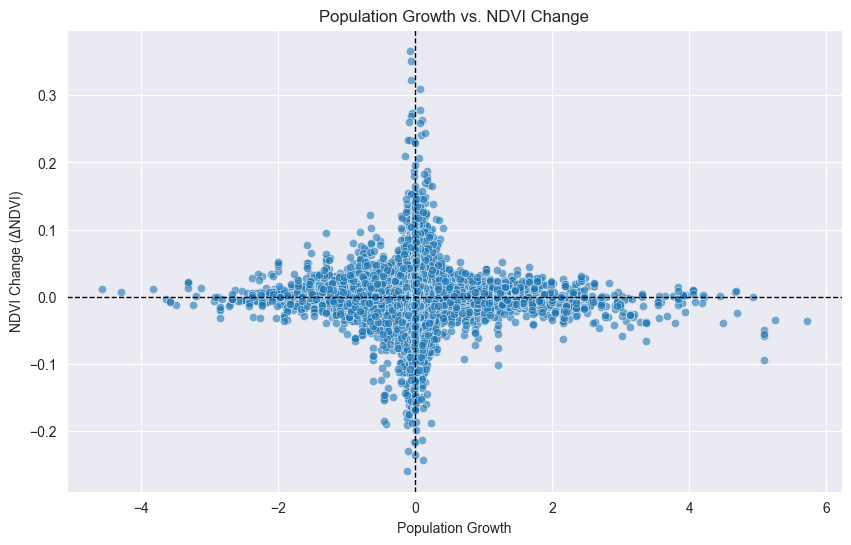

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis["ΔPOP"], y=df_analysis["ΔNDVI"], alpha=0.6)
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Zero reference line
plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Zero reference line
plt.xlabel("Population Growth")
plt.ylabel("NDVI Change (ΔNDVI)")
plt.title("Population Growth vs. NDVI Change")
plt.show()


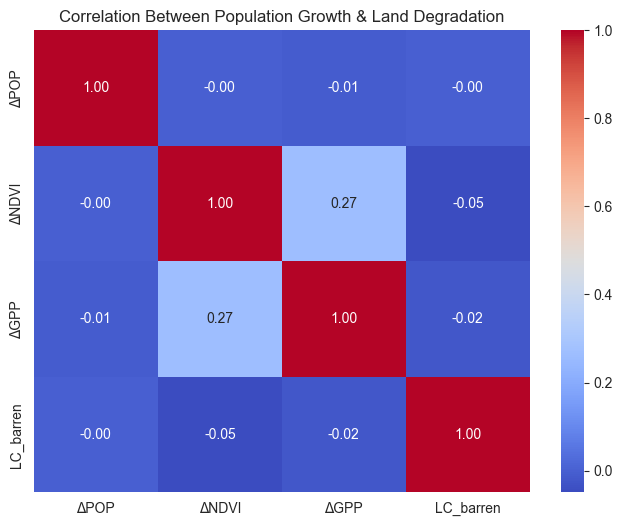

In [44]:
corr_matrix = df_analysis[["ΔPOP", "ΔNDVI", "ΔGPP", "LC_barren"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Population Growth & Land Degradation")
plt.show()


R² Score: 0.0000


C:\Users\tilma\PycharmProjects\pythonProject\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


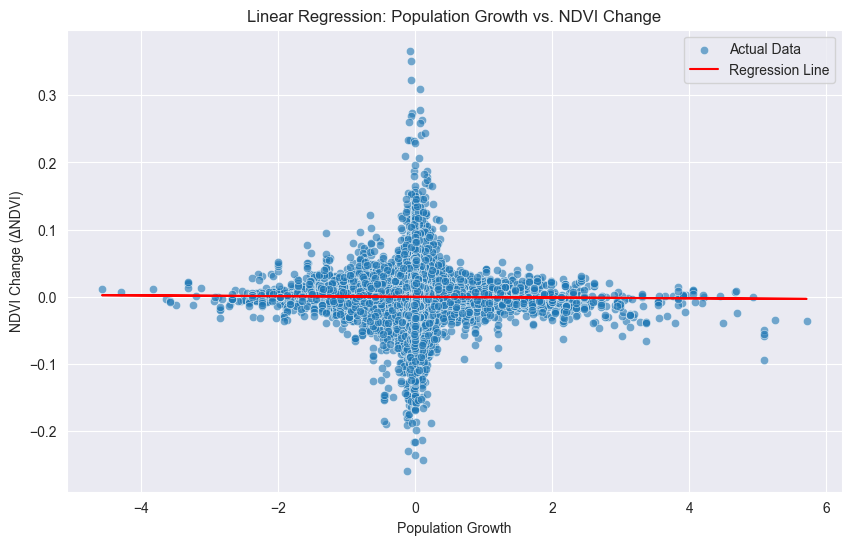

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare regression model
X = df_analysis[["ΔPOP"]].values  # Population Growth
y = df_analysis["ΔNDVI"].values  # NDVI Change

# Train Linear Regression
reg = LinearRegression()
reg.fit(X, y)

# Predict
y_pred = reg.predict(X)

# Evaluate R² score
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

# Plot regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X.flatten(), y=y, alpha=0.6, label="Actual Data")
plt.plot(X.flatten(), y_pred, color="red", label="Regression Line")
plt.xlabel("Population Growth")
plt.ylabel("NDVI Change (ΔNDVI)")
plt.title("Linear Regression: Population Growth vs. NDVI Change")
plt.legend()
plt.show()


   year  is_regenerated      NDVI  GPP    LC
0  2010               0  0.100435  0.0  16.0
1  2010               0  0.108242  0.0  16.0
2  2010               0  0.100624  0.0  16.0
3  2010               0  0.109151  0.0  16.0
4  2010               0  0.101587  0.0  16.0


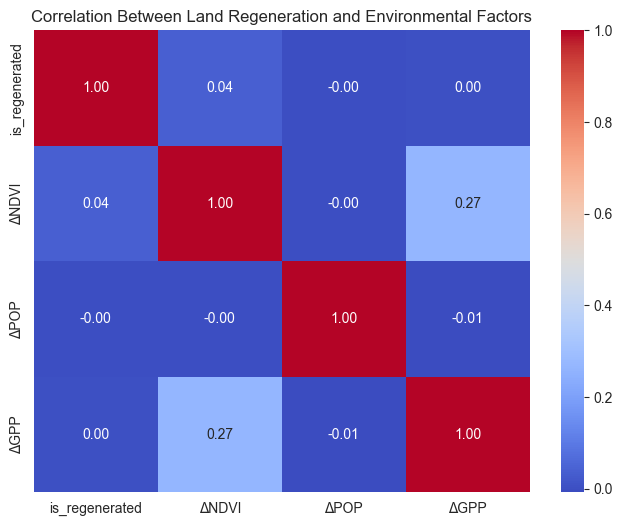

In [47]:
# Define threshold for NDVI recovery (e.g., >0.1 change)
ndvi_threshold = 0.1

# Define Land Regeneration: NDVI increase + shift away from barren land (16)
df_transformed["is_regenerated"] = (
    (df_transformed["NDVI"] - df_transformed["NDVI"].shift(1) > ndvi_threshold) & 
    (df_transformed["LC"].shift(1) == 16) &  # Previously barren
    (df_transformed["LC"].isin([1, 2, 3, 4, 5, 7,10]))  # Now vegetated
).astype(int)

# Drop NaN rows caused by shifting
df_regeneration = df_transformed.dropna(subset=["is_regenerated"])
print(df_regeneration[["year", "is_regenerated", "NDVI", "GPP", "LC"]].head())
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features
corr_matrix = df_regeneration[["is_regenerated", "ΔNDVI", "ΔPOP",  "ΔGPP"]].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Land Regeneration and Environmental Factors")
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_regeneration["ΔPRECIP"], y=df_regeneration["ΔNDVI"], alpha=0.6)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Change in Precipitation (ΔPRECIP)")
plt.ylabel("NDVI Change (ΔNDVI)")
plt.title("Impact of Rainfall on Vegetation Recovery")
plt.show()


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

df_regeneration["ΔLST"] = df_regeneration["LST"] - df_regeneration["LST"].shift(1)

# Define features for prediction
feature_cols = ["ΔNDVI", "ΔPOP",  "ΔGPP", "ΔLST"]

# Drop missing values
df_clean = df_regeneration.dropna(subset=feature_cols + ["is_regenerated"])

# Train-Test Split (2010-2020 for training, 2021-2022 for testing)
df_train = df_clean[df_clean["year"] <= 2020]
df_test = df_clean[df_clean["year"] > 2020]

X_train = df_train[feature_cols].values
y_train = df_train["is_regenerated"].values

X_test = df_test[feature_cols].values
y_test = df_test["is_regenerated"].values

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    504627
           1       0.50      0.11      0.18         9

    accuracy                           1.00    504636
   macro avg       0.75      0.56      0.59    504636
weighted avg       1.00      1.00      1.00    504636



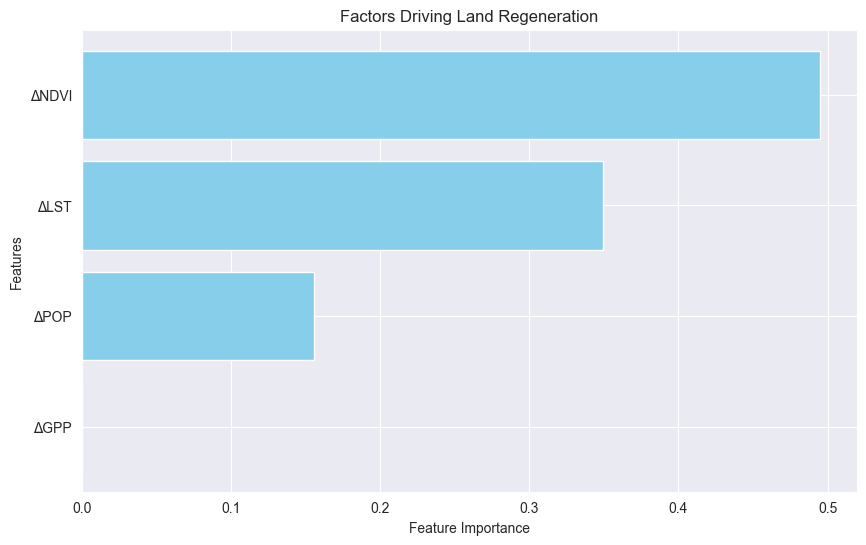

In [51]:
import numpy as np

# Get feature importances
feature_importances = clf.feature_importances_

# Sort by importance
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(feature_cols)[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Factors Driving Land Regeneration")
plt.show()


In [52]:
# Predict land recovery for 2023
df["regen_risk_2023"] = clf.predict_proba(df_test[feature_cols])[:, 1]

# Predict for 2024 using 2023 data
df_test["is_regenerated"] = df["regen_risk_2023"]  # Simulated for 2023
df["regen_risk_2024"] = clf.predict_proba(df_test[feature_cols])[:, 1]

print("Predictions for 2023 and 2024 land regeneration added!")


C:\Users\tilma\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: Length of values (504636) does not match length of index (168212)

In [ ]:
def plot_regeneration_map(df, year):
    plt.figure(figsize=(10, 6))
    plt.scatter(df["xcoord"], df["ycoord"], c=df[f"regen_risk_{year}"], cmap="Greens", alpha=0.6)
    plt.colorbar(label=f"Predicted Regeneration Probability {year}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Predicted Land Regeneration - {year}")
    plt.show()

plot_regeneration_map(df, 2023)
plot_regeneration_map(df, 2024)


In [87]:
import pandas as pd
from sqlalchemy import create_engine

# Save to SQLite
engine = create_engine("sqlite:///data.db")
df_transformed.to_sql("dataset", engine, if_exists="replace", index=False)


2354968

In [96]:
import openai
import sqlite3
import text

openai.api_key = #
def run_query(nl_question):
    # Connect to the DB
    conn = sqlite3.connect("data.db")
    cursor = conn.cursor()

    # Let GPT-4 generate a SQL query
    prompt = f"""
    You are a data analyst. Convert the following question into a SQL query on a table named 'dataset'. 
    Then, explain the result in a short paragraph.

    Question: {nl_question}
    
    ### Context
    {text.CONTEXT}
    """
    client = openai.OpenAI(api_key=openai.api_key)
    response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "user", "content": "Your question here"}
    ],
    temperature=0.7
    )
    
    print(response.choices[0].message.content)

    # Extract SQL and explanation
    gpt_output = response["choices"][0]["message"]["content"]
    print("🧠 GPT Output:\n", gpt_output)

    # OPTIONAL: You can extract and execute the SQL if needed
    import re
    match = re.search(r"```sql\n(.*?)\n```", gpt_output, re.DOTALL)
    if match:
        sql_query = match.group(1)
        result_df = pd.read_sql_query(sql_query, conn)
        print("📊 Data Output:\n", result_df.head())
        conn.close()
        return result_df, gpt_output
    else:
        return None, gpt_output
    
    


In [97]:
run_query("What is the biggest land coverage and how can we preserve as much land as possible?")

What is the capital of Australia?


TypeError: 'ChatCompletion' object is not subscriptable